In [1]:
from datasets import load_dataset

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [3]:
dataset = load_dataset("naver-clova-ix/cord-v2")

Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (/Users/piriyan_karu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [5]:
train, val, test = dataset["train"], dataset["validation"], dataset["test"]


In [6]:
images = train['image']
labels = train['ground_truth']

(1296, 864, 3)
(1296, 864, 3)
(1280, 720, 3)
(1478, 1108, 3)
(1296, 864, 3)
(4096, 2304, 3)
(1296, 864, 3)
(1296, 864, 3)
(1296, 864, 3)


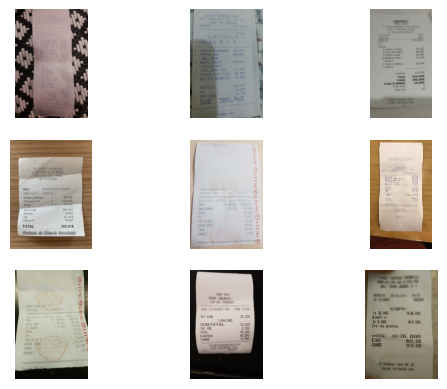

In [7]:
#plt.figure((10,10))
for i in range(9):
    print(np.array(images[i]).shape)
    plt.subplot(3,3,i+1)
    plt.imshow(np.array(images[i]))
    plt.axis('off')

In [8]:
a = eval(labels[200])
vl = a['valid_line']

In [9]:
vl2 = [i for i in vl if i['category'] == 'menu.price']

In [10]:
vl2

[{'words': [{'quad': {'x2': 684,
     'y3': 872,
     'x3': 684,
     'y4': 872,
     'x1': 602,
     'y1': 838,
     'x4': 602,
     'y2': 838},
    'is_key': 0,
    'row_id': 2101887,
    'text': '6.000'}],
  'category': 'menu.price',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 684,
     'y3': 914,
     'x3': 683,
     'y4': 911,
     'x1': 588,
     'y1': 879,
     'x4': 587,
     'y2': 882},
    'is_key': 0,
    'row_id': 2101888,
    'text': '43,636'}],
  'category': 'menu.price',
  'group_id': 4,
  'sub_group_id': 0}]

In [11]:
def getImageData(parse):
    dict_parse = eval(parse) #get dictionary form of string parse
    meta = dict_parse['meta']
    valid_line = dict_parse['valid_line']
    valid_lines = [i for i in valid_line if i['category'] == 'menu.price']
    image_size = meta['image_size']
    #Getting image size of image
    width, height = image_size['width'], image_size['height']
    
    all_data = []
    
    words, boxes = [],[]
    for line in valid_lines:
        for word in line['words']:
            quad = word['quad']
            x1, x3, y1, y3 = quad['x1'],quad['x3'],quad['y1'],quad['y3']
            box = [x1,y1,x3,y3]
            
            words.append(word['text'])
            boxes.append(box)
    
    return width, height, words, boxes

In [12]:
def deriveLabels(labels):
    derivedLabels = []
    for label in labels:
        w, h, words, boxes = getImageData(label)
        derivedLabels.append([w, h, words, boxes])
    
    return derivedLabels

In [13]:
new_labels = deriveLabels(labels)

In [14]:
"""INDEX = 508
image = images[INDEX]

draw = ImageDraw.Draw(image, "RGBA")
w, h, words, boxes = new_labels[INDEX]
print(words[:10])
print(boxes[:10])
for index, word in enumerate(words):
    box = boxes[index]
    draw.rectangle(box, width=2)
    draw.text((box[0]+10, box[1]+5), word, fill = 'red')"""

'INDEX = 508\nimage = images[INDEX]\n\ndraw = ImageDraw.Draw(image, "RGBA")\nw, h, words, boxes = new_labels[INDEX]\nprint(words[:10])\nprint(boxes[:10])\nfor index, word in enumerate(words):\n    box = boxes[index]\n    draw.rectangle(box, width=2)\n    draw.text((box[0]+10, box[1]+5), word, fill = \'red\')'

In [15]:
train_images = images
train_labels = new_labels

val_images = val['image']
val_labels = deriveLabels(val["ground_truth"])

test_images = test['image']
test_labels = deriveLabels(test["ground_truth"])

In [16]:
INDEX_IMAGE = 508
data = pd.DataFrame({'width': train_labels[INDEX_IMAGE][0], 'height': train_labels[INDEX_IMAGE][1], 'Words': train_labels[INDEX_IMAGE][2], 'Boxes': train_labels[INDEX_IMAGE][3] })

In [17]:
data

,width,height,Words,Boxes
0,576,864,"8.500,00","[380, 422, 484, 450]"
1,576,864,"6.000,00","[380, 482, 481, 515]"
2,576,864,"6.500,00","[378, 545, 481, 579]"
3,576,864,"0,00","[426, 612, 482, 642]"


In [18]:
train_labels[INDEX_IMAGE]

[576,
 864,
 ['8.500,00', '6.000,00', '6.500,00', '0,00'],
 [[380, 422, 484, 450],
  [380, 482, 481, 515],
  [378, 545, 481, 579],
  [426, 612, 482, 642]]]

In [66]:
def getTrainDataset(images, image_data):
    new_images = []
    new_data = []
    lens = []
    for index, image in enumerate(images):
        data_vals = image_data[index]
        lens.append(len(data_vals[3]))
        w, h = data_vals[0], data_vals[1]
        new_image = img_to_array(image.resize((224,224)))
        for data in image_data[index][3]:
            new_images.append(new_image)
            x1 = float(data[0]) / w
            y1 = float(data[1]) / h
            x3 = float(data[2]) / w
            y3 = float(data[3]) / h
            new_data.append((x1,y1,x3,y3))
    
    new_images = np.array(new_images, dtype='float32') / 255.0
    new_data = np.array(new_data)
    return (new_images, new_data, lens)

In [73]:
train_data, train_gt, lens= getTrainDataset(train_images, train_labels)
val_data, val_gt, val_lens = getTrainDataset(val_images, val_labels)

In [74]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [81]:
vgg16_model = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

vgg16_model.trainable = False

In [83]:
model = keras.models.Sequential([
    vgg16_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation="sigmoid")
])

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 17,936,548
Trainable params: 3,221,860
Non

In [88]:
EPOCHS = 25
BATCH_SIZE = 32
history = model.fit(train_data,train_gt,
                    validation_data = (val_data,val_gt),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS
                   )

Epoch 1/25
67/67 [==============================] - 269s 4s/step - loss: 0.0854 - val_loss: 0.0770
Epoch 2/25
67/67 [==============================] - 268s 4s/step - loss: 0.0808 - val_loss: 0.0809
Epoch 3/25
67/67 [==============================] - 260s 4s/step - loss: 0.0811 - val_loss: 0.0772
Epoch 4/25
67/67 [==============================] - 259s 4s/step - loss: 0.0807 - val_loss: 0.0772
Epoch 5/25
67/67 [==============================] - 260s 4s/step - loss: 0.0802 - val_loss: 0.0770
Epoch 6/25
67/67 [==============================] - 260s 4s/step - loss: 0.0212 - val_loss: 0.0060
Epoch 7/25
67/67 [==============================] - 266s 4s/step - loss: 0.0054 - val_loss: 0.0028
Epoch 8/25
67/67 [==============================] - 260s 4s/step - loss: 0.0046 - val_loss: 0.0031
Epoch 9/25
67/67 [==============================] - 260s 4s/step - loss: 0.0042 - val_loss: 0.0030
Epoch 10/25
67/67 [==============================] - 266s 4s/step - loss: 0.0041 - val_loss: 0.0034
Epoch 11/

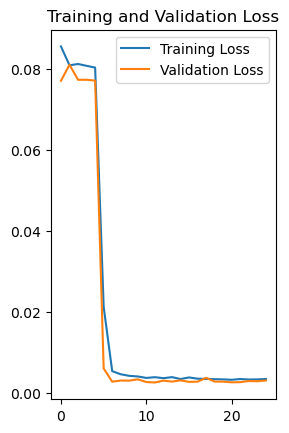

In [91]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [92]:
model.save('./')

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [230]:
test_data = test_images[0]
tl = test_labels[0]
w,h = tl[0], tl[1]

test_data = img_to_array(test_data.resize((224,224)))

In [231]:
tl

[432, 648, ['60.000'], [[174, 410, 224, 430]]]

In [232]:
test_data = np.expand_dims(test_data, axis=0)

In [233]:
preds = model.predict(test_data)

1/1 [==============================] - 1s 520ms/step


In [234]:
(x1, y1, x3, y3) = preds[0]

In [235]:
x1 = int(x1 * w)
y1 = int(y1 * h)
x3 = int(x3 * w)
y3 = int(y3 * h)

In [236]:
pred_img = test_images[1]

In [237]:
box = [x1,y1,x3,y3]

In [238]:
box

[432, 647, 432, 647]

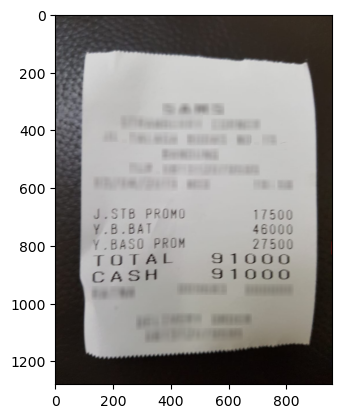

In [204]:
from matplotlib.patches import Rectangle
plt.imshow(pred_img)

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((x1,y1),(x3-x1),(y3-y1),linewidth=1,edgecolor='r',facecolor='none'))

In [172]:
def getTrainDataset2(images, image_data):
    new_images = []
    new_data = []
    lens = []
    for index, image in enumerate(images):
        data_vals = image_data[index]
        lens.append(len(data_vals[3]))
        w, h = data_vals[0], data_vals[1]
        new_image = img_to_array(image.resize((224,224)))
        count = 0
        for data in image_data[index][3]:
            if (count == 1): break
            new_images.append(new_image)
            x1 = float(data[0]) / w
            y1 = float(data[1]) / h
            x3 = float(data[2]) / w
            y3 = float(data[3]) / h
            new_data.append((x1,y1,x3,y3))
            count += 1
    
    new_images = np.array(new_images, dtype='float32') / 255.0
    new_data = np.array(new_data)
    return (new_images, new_data, lens)

In [173]:
ti2, tl2, len3 = getTrainDataset2(train_images, train_labels)
vt2, vl2, len4 = getTrainDataset2(val_images, val_labels)

In [174]:
model2 = tf.keras.models.clone_model(model)

In [176]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

In [177]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 17,936,548
Trainable params: 3,221,860
Non

In [183]:
EPOCHS = 25
BATCH_SIZE = 32
history2 = model2.fit(ti2,tl2,
                    validation_data = (vt2,vl2),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS
                   )

Epoch 1/25
25/25 [==============================] - 108s 4s/step - loss: 0.0194 - val_loss: 0.0088
Epoch 2/25
25/25 [==============================] - 100s 4s/step - loss: 0.0104 - val_loss: 0.0071
Epoch 3/25
25/25 [==============================] - 99s 4s/step - loss: 0.0101 - val_loss: 0.0071
Epoch 4/25
25/25 [==============================] - 100s 4s/step - loss: 0.0100 - val_loss: 0.0070
Epoch 5/25
25/25 [==============================] - 100s 4s/step - loss: 0.0100 - val_loss: 0.0070
Epoch 6/25
25/25 [==============================] - 100s 4s/step - loss: 0.0099 - val_loss: 0.0070
Epoch 7/25
25/25 [==============================] - 100s 4s/step - loss: 0.0098 - val_loss: 0.0069
Epoch 8/25
25/25 [==============================] - 101s 4s/step - loss: 0.0099 - val_loss: 0.0070
Epoch 9/25
25/25 [==============================] - 100s 4s/step - loss: 0.0097 - val_loss: 0.0068
Epoch 10/25
25/25 [==============================] - 101s 4s/step - loss: 0.0097 - val_loss: 0.0067
Epoch 11/2

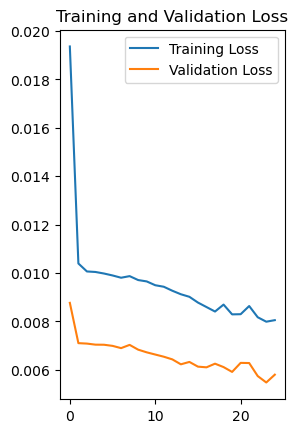

In [184]:

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [225]:
preds2 = model2.predict(test_data)

1/1 [==============================] - 0s 150ms/step


In [226]:
(px1, py1, px3, py3) = preds2[0]

In [227]:
px1 = int(px1) * w
py1 = int(py1) * h
px3 = int(px3) * w
py3 = int(py3) * h

In [228]:
box = [px1, py1, px3, py3]

In [229]:
box

[960, 0, 960, 0]